In [82]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('demo_run_06_05_2025_exported_data/001_M3A2H7Q4.csv', comment='#')

/tmp/ipykernel_51868/56676076.py:1: DtypeWarning: Columns (3,4,6,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('demo_run_06_05_2025_exported_data/001_M3A2H7Q4.csv', comment='#')


In [15]:
interpolated_data = data.interpolate('pad')

/tmp/ipykernel_51868/1498507336.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data = data.interpolate('pad')


In [29]:
trimmed_data = interpolated_data[['Timestamp', 'Channel 13 (Raw)','Channel 9 (Raw)', 'MarkerName','MarkerDescription','MarkerType', 'DistanceToNextSpeedSign', 'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
       'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight']]

In [34]:
trimmed_data['MarkerName'][trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']!='Experiment')]

61474        CalmAudio
61475        CalmAudio
61476        CalmAudio
61477        CalmAudio
61478        CalmAudio
              ...     
422771    IntenseAudio
422772    IntenseAudio
422773    IntenseAudio
422774    IntenseAudio
422775    IntenseAudio
Name: MarkerName, Length: 361302, dtype: object

In [96]:
before_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[0]
before_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[-1]

calm_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
calm_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

interim_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
interim_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

intense_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
intense_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

after_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]
after_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='E')].iloc[-1]

In [77]:
classes = {'Before':before_audio.iloc[0]['Timestamp'], 'Calm':calm_audio.iloc[0]['Timestamp'], 'Interim':interim_audio.iloc[0]['Timestamp'], 'Intense':intense_audio.iloc[0]['Timestamp'], 'After':after_audio.iloc[0]['Timestamp'] }

In [97]:
before_range = np.arange(before_audio_start['Timestamp'], before_audio_end['Timestamp'])
calm_range = np.arange(calm_audio_start['Timestamp'], calm_audio_end['Timestamp'])
interim_range = np.arange(interim_audio_start['Timestamp'],interim_audio_end['Timestamp'])
intense_range = np.arange(intense_audio_start['Timestamp'], intense_audio_end['Timestamp'])
after_range = np.arange(after_audio_start['Timestamp'], after_audio_end['Timestamp'])
total_range = np.arange(before_audio_start['Timestamp'],after_audio_end['Timestamp']) 
  # before_audio.iloc[0]['Timestamp'],calm_audio.iloc[0]['Timestamp'],interim_audio.iloc[0]['Timestamp'], intense_audio.iloc[0]['Timestamp'],after_audio.iloc[0]['Timestamp'] ]

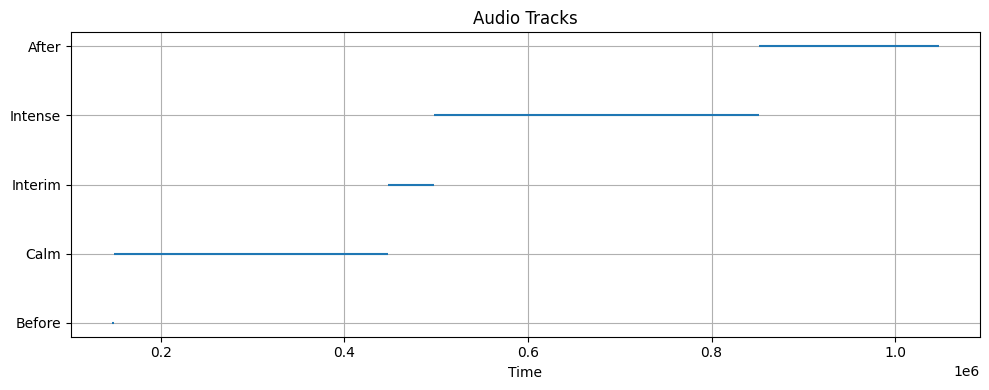

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

# Example Y positions for each class
class_labels = ['Before', 'Calm', 'Interim', 'Intense', 'After']
class_y = {
    'before': 0,
    'calm': 1,
    'interim': 2,
    'intense': 3,
    'after': 4
}

# Draw horizontal lines for each class range
ax.hlines(y=class_y['before'], xmin=before_range[0], xmax=before_range[-1], label='Before')
ax.hlines(y=class_y['calm'], xmin=calm_range[0], xmax=calm_range[-1], label='Calm')
ax.hlines(y=class_y['interim'], xmin=interim_range[0], xmax=interim_range[-1], label='Interim')
ax.hlines(y=class_y['intense'], xmin=intense_range[0], xmax=intense_range[-1], label='Intense')
ax.hlines(y=class_y['after'], xmin=after_range[0], xmax=after_range[-1], label='After')

ax.set_yticks(list(class_y.values()))
ax.set_yticklabels(class_labels)
ax.set_xlabel('Time')
ax.set_title('Audio Tracks')
ax.grid(True)
plt.tight_layout()
plt.show()


In [76]:
calm_audio.iloc[0]['Timestamp']

np.float64(149354.359)

<Axes: >

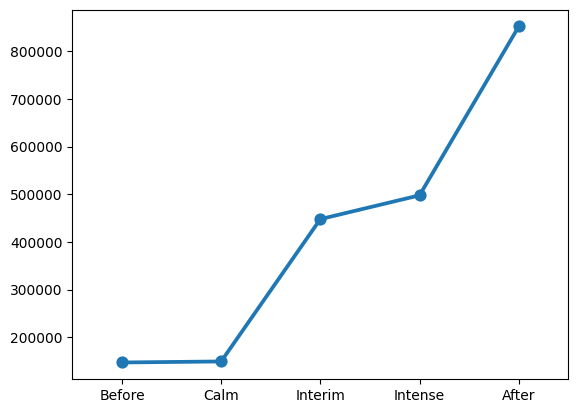

In [78]:
import seaborn as sns

import matplotlib.pyplot as plt

sns.pointplot(classes)